In [9]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Compose, RandomRotation
from torch.utils.data import DataLoader, random_split

# 数据加载及分割
transform = ToTensor()
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 分割训练集和验证集
train_size = 50000
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# DataLoader
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
import torch.nn as nn
import torch.nn.functional as F

# 定义CNN模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 3 * 3, 10)  # Fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # Flatten the tensor
        x = self.fc(x)
        return x


In [13]:
# Train and validate the model
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        history["train_loss"].append(train_loss / len(train_loader))
        history["train_acc"].append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(val_acc)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {history['train_loss'][-1]:.4f}, "
              f"Train Acc: {history['train_acc'][-1]:.2f}%, Val Loss: {history['val_loss'][-1]:.4f}, "
              f"Val Acc: {history['val_acc'][-1]:.2f}%")

    return history


In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define different data augmentation methods
augmentation_methods = {
    "baseline": transforms.Compose([transforms.ToTensor()]),
    "random_flip": transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
        transforms.ToTensor()
    ]),
    "random_rotation": transforms.Compose([
        transforms.RandomRotation(degrees=15),  # Randomly rotate the image by up to 15 degrees
        transforms.ToTensor()
    ]),
    "scale": transforms.Compose([
        transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.2)),  # Randomly resize and crop
        transforms.ToTensor()
    ]),
    "combined": transforms.Compose([
        transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.2)),  # Combine scaling
        transforms.RandomHorizontalFlip(p=0.5),  # Combine flipping
        transforms.RandomRotation(degrees=15),  # Combine rotation
        transforms.ToTensor()
    ])
}

# Load MNIST dataset (training and validation split)
def load_data(transform, batch_size=16):
    # Load the full dataset with the given transform
    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # Split into training and validation datasets
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_data, val_data = random_split(full_dataset, [train_size, val_size])
    # Create data loaders for training and validation sets
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


In [18]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(dataloader), accuracy

In [25]:
from torch import optim

# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}

# Train the model with each augmentation method
for name, transform in augmentation_methods.items():
    print(f"\nTraining with augmentation: {name}")
    train_loader, val_loader = load_data(transform)

    # Initialize model, loss function, and optimizer
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model and store results
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)
    results[name] = history
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")




Training with augmentation: baseline
Epoch 1/10, Train Loss: 0.1748, Train Acc: 94.44%, Val Loss: 0.0581, Val Acc: 98.17%
Epoch 2/10, Train Loss: 0.0564, Train Acc: 98.22%, Val Loss: 0.0575, Val Acc: 98.20%
Epoch 3/10, Train Loss: 0.0400, Train Acc: 98.72%, Val Loss: 0.0535, Val Acc: 98.30%
Epoch 4/10, Train Loss: 0.0289, Train Acc: 99.11%, Val Loss: 0.0632, Val Acc: 98.10%
Epoch 5/10, Train Loss: 0.0246, Train Acc: 99.19%, Val Loss: 0.0377, Val Acc: 98.82%
Epoch 6/10, Train Loss: 0.0200, Train Acc: 99.35%, Val Loss: 0.0435, Val Acc: 98.63%
Epoch 7/10, Train Loss: 0.0168, Train Acc: 99.43%, Val Loss: 0.0339, Val Acc: 98.96%
Epoch 8/10, Train Loss: 0.0127, Train Acc: 99.58%, Val Loss: 0.0385, Val Acc: 98.90%
Epoch 9/10, Train Loss: 0.0118, Train Acc: 99.61%, Val Loss: 0.0324, Val Acc: 99.12%
Epoch 10/10, Train Loss: 0.0100, Train Acc: 99.68%, Val Loss: 0.0574, Val Acc: 98.70%
Test Loss: 0.0476, Test Acc: 98.82%

Training with augmentation: random_flip
Epoch 1/10, Train Loss: 0.2816, Tr

In [27]:
import matplotlib.pyplot as plt


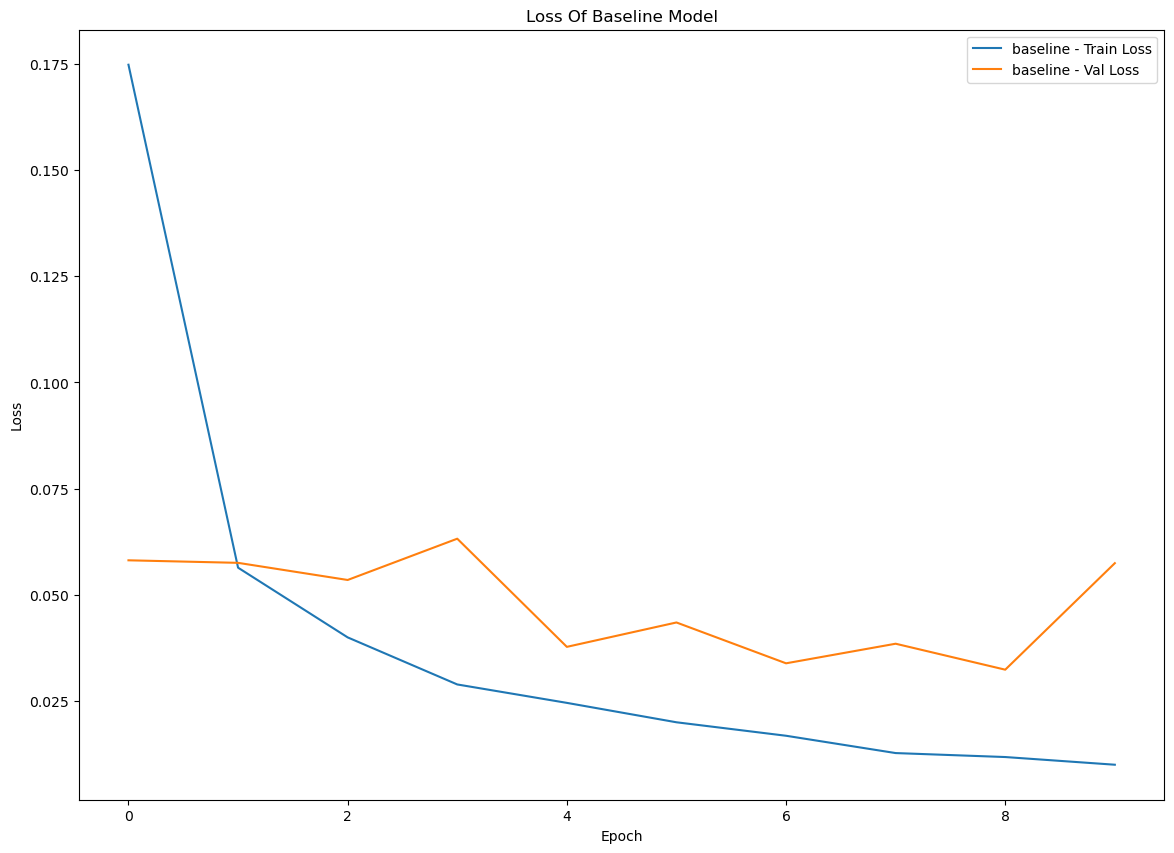

In [32]:
plt.figure(figsize=(14, 10))
name = 'baseline'
history = results[name]
plt.plot(history["train_loss"], label=f"{name} - Train Loss")
plt.plot(history["val_loss"], label=f"{name} - Val Loss")
plt.title("Loss Of Baseline Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

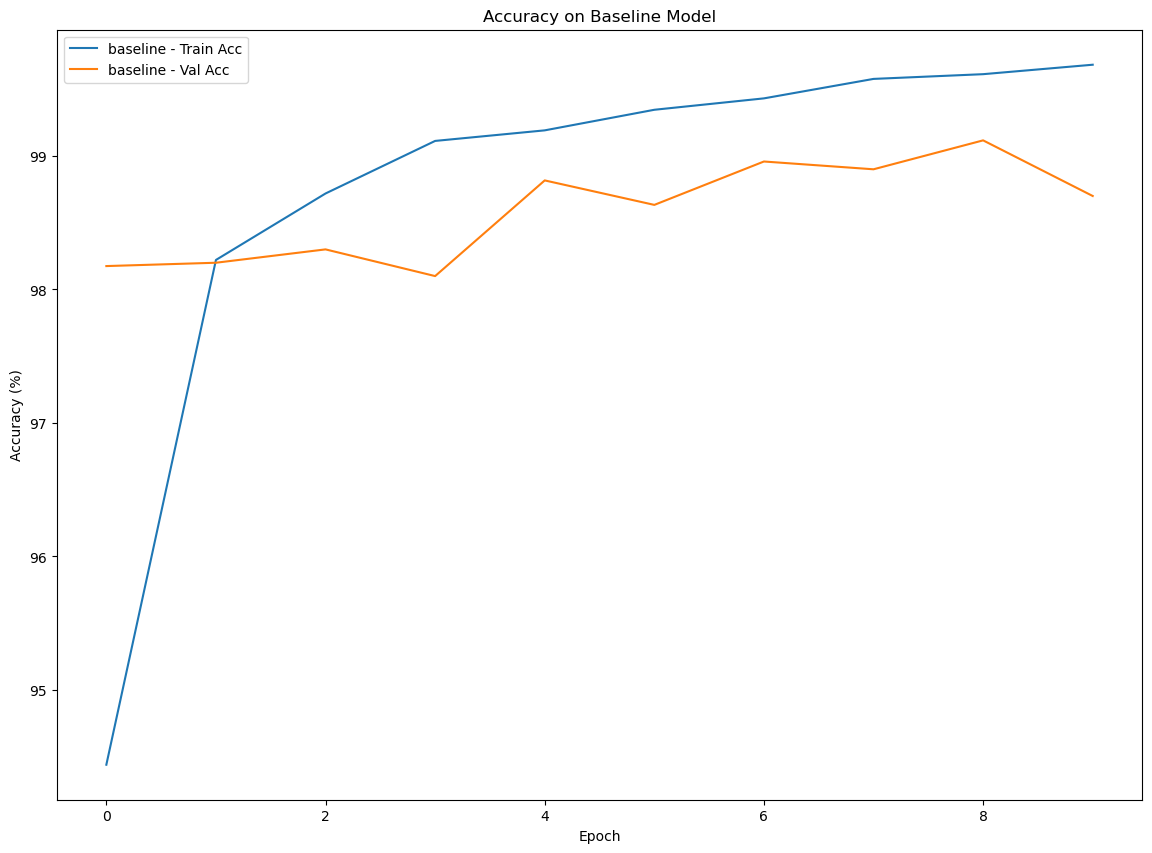

In [33]:
plt.figure(figsize=(14, 10))
name = 'baseline'
history = results[name]
plt.plot(history["train_acc"], label=f"{name} - Train Acc")
plt.plot(history["val_acc"], label=f"{name} - Val Acc")
plt.title("Accuracy on Baseline Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

In [39]:
name_map = {
    "random_flip": "Random Flip", "random_rotation": "Random Rotation", "scale": "Random Scale", "combined": "Combined"
}

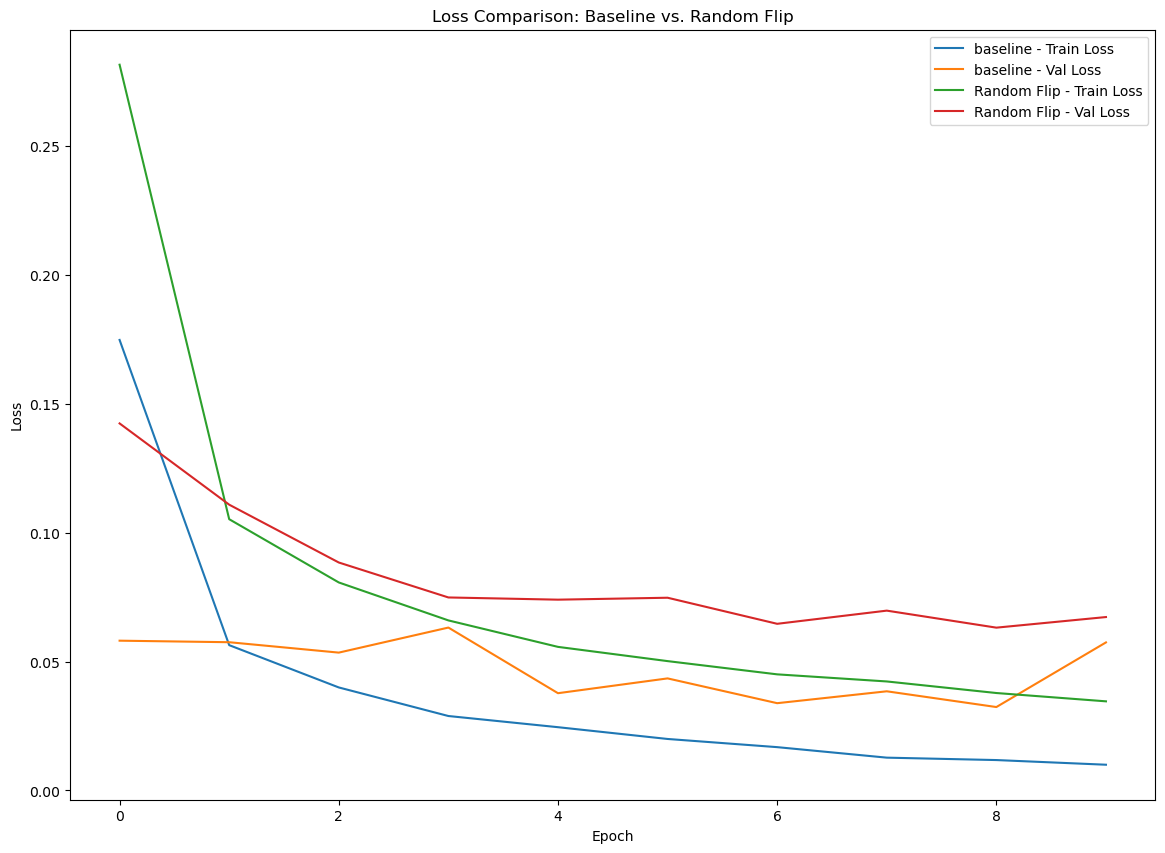

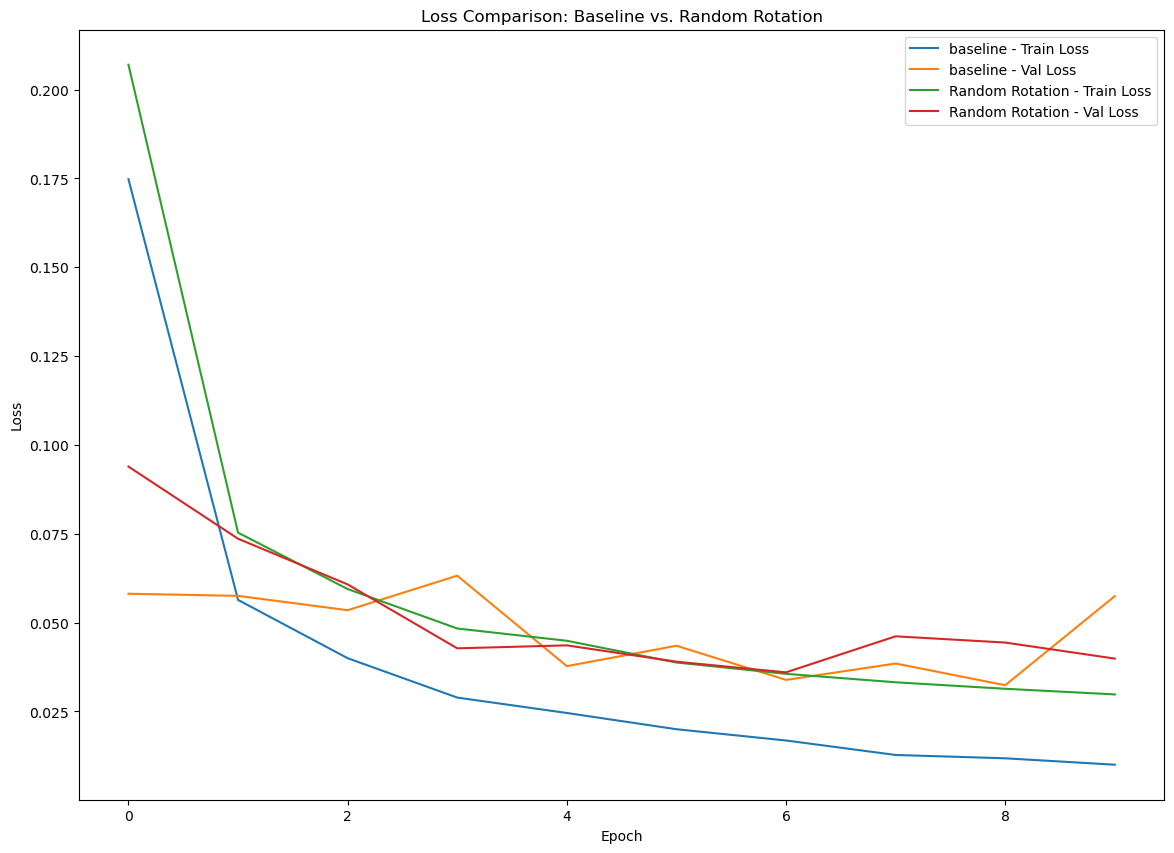

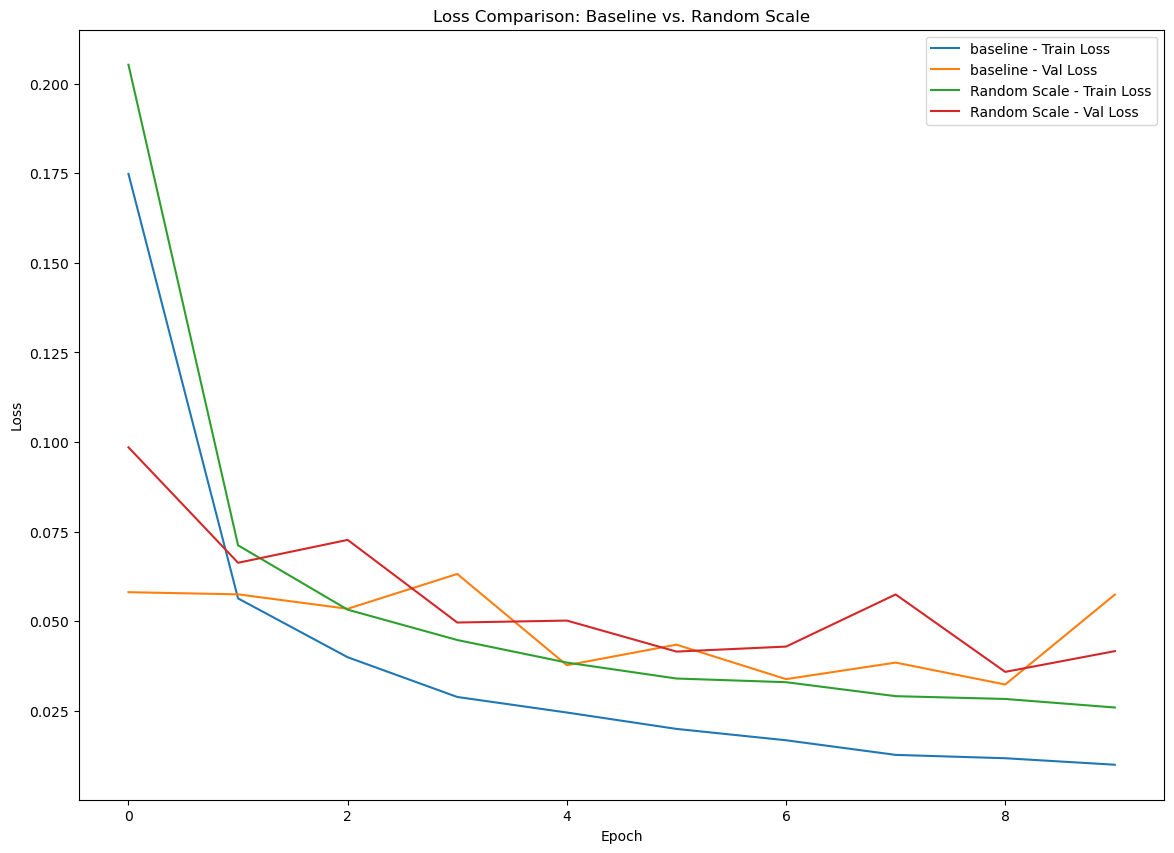

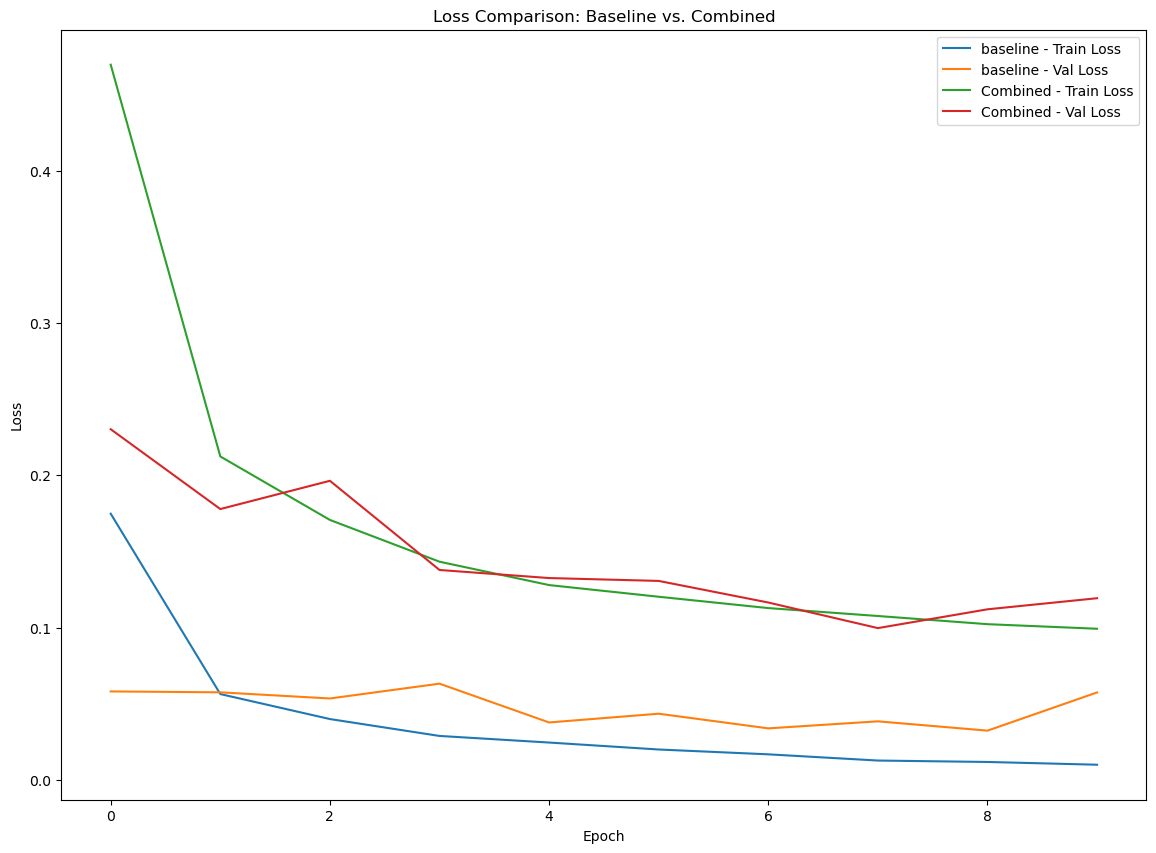

In [40]:
compare_names = ["random_flip", "random_rotation", "scale", "combined"]
for other_name in compare_names:
    plt.figure(figsize=(14, 10))
    name = 'baseline'
    history = results[name]
    plt.plot(history["train_loss"], label=f"{name} - Train Loss")
    plt.plot(history["val_loss"], label=f"{name} - Val Loss")
    name = name_map[other_name]
    history = results[other_name]
    plt.plot(history["train_loss"], label=f"{name} - Train Loss")
    plt.plot(history["val_loss"], label=f"{name} - Val Loss")
    plt.title(f"Loss Comparison: Baseline vs. {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

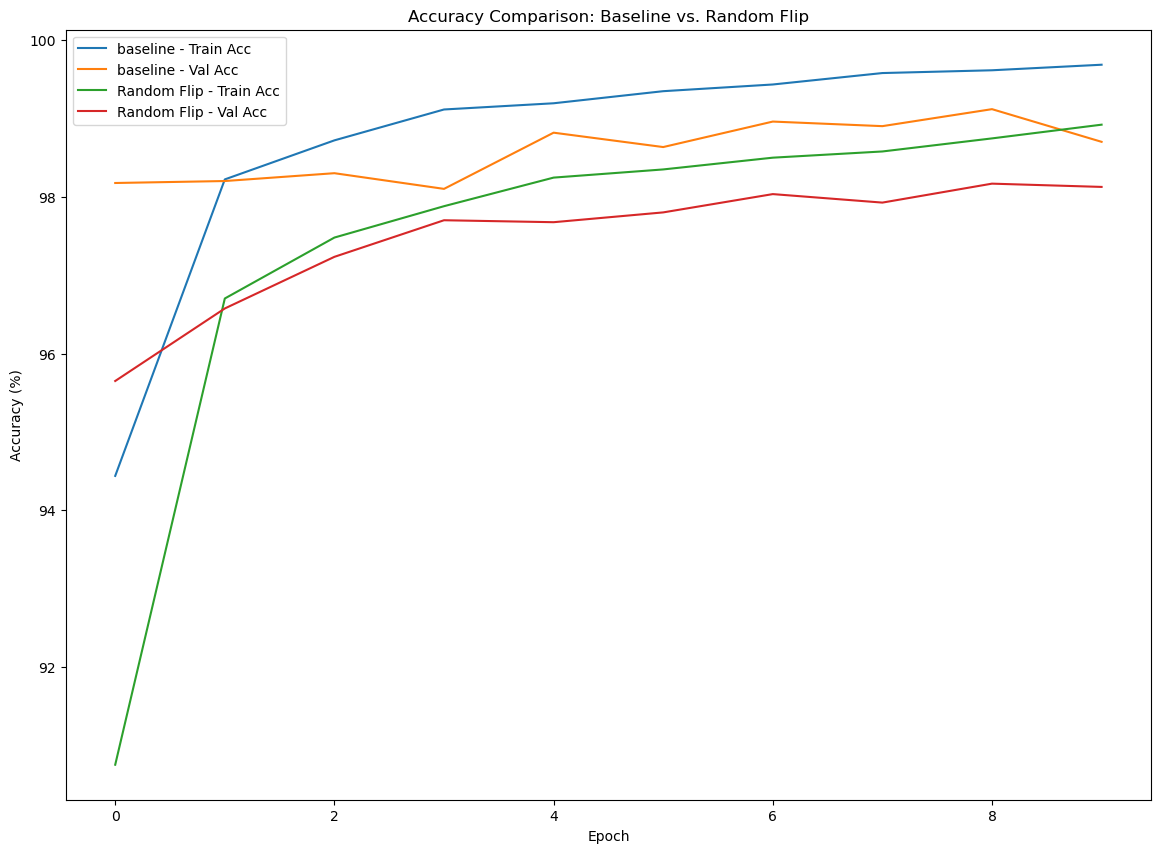

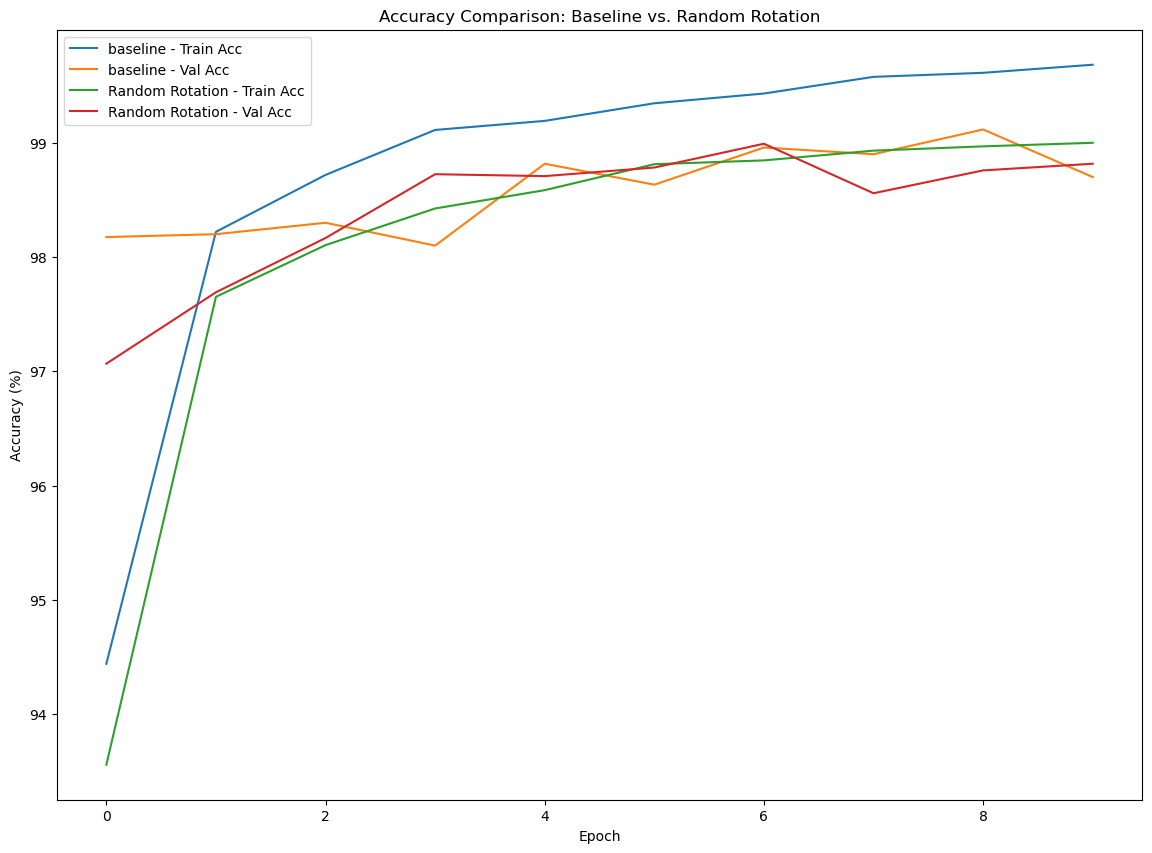

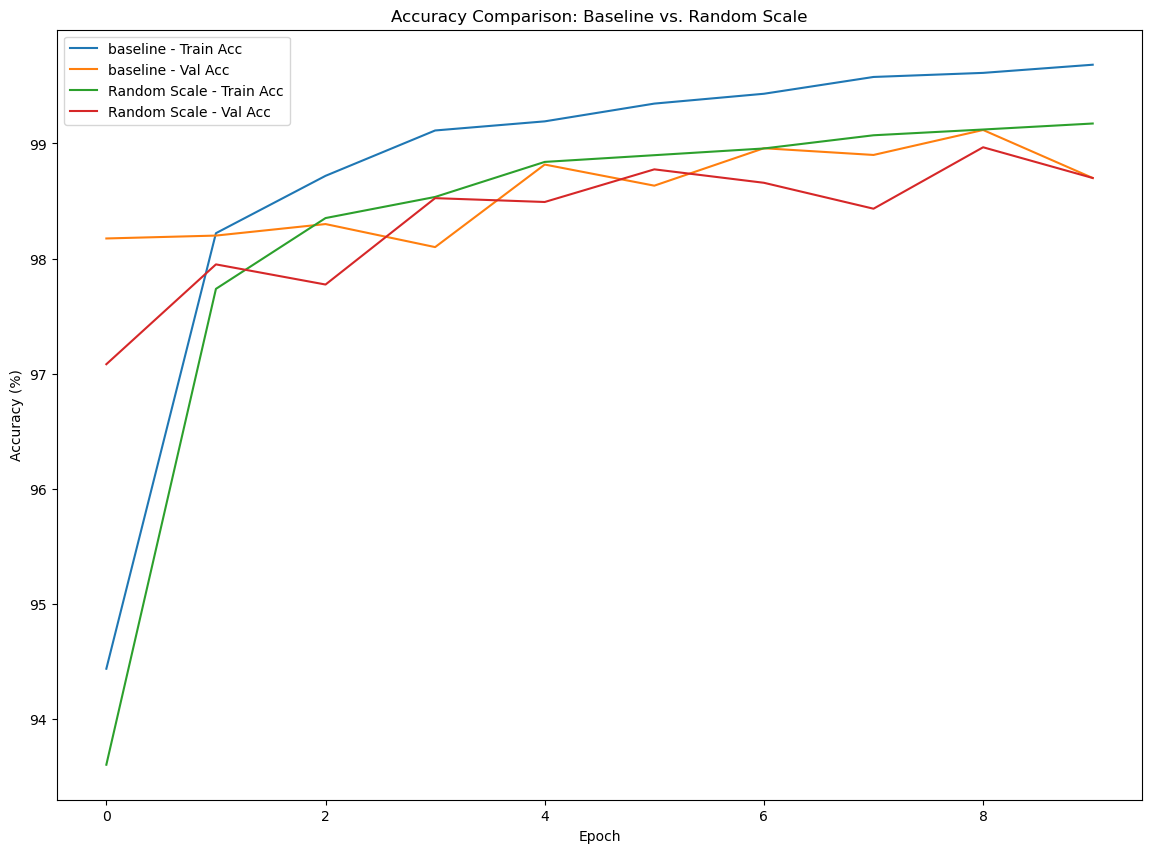

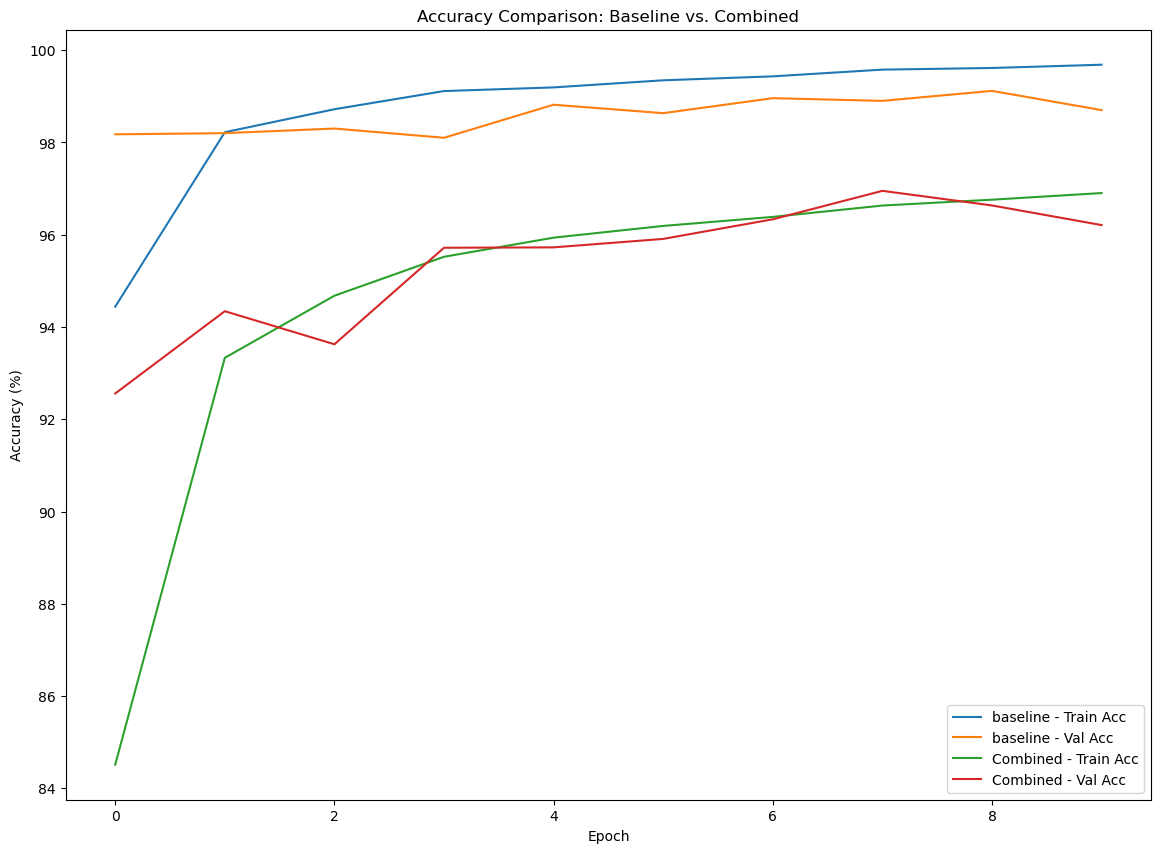

In [41]:
compare_names = ["random_flip", "random_rotation", "scale", "combined"]
for other_name in compare_names:
    plt.figure(figsize=(14, 10))
    name = 'baseline'
    history = results[name]
    plt.plot(history["train_acc"], label=f"{name} - Train Acc")
    plt.plot(history["val_acc"], label=f"{name} - Val Acc")
    name = name_map[other_name]
    history = results[other_name]
    plt.plot(history["train_acc"], label=f"{name} - Train Acc")
    plt.plot(history["val_acc"], label=f"{name} - Val Acc")
    plt.title(f"Accuracy Comparison: Baseline vs. {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()